# I. US Living Kidney Donor Candidates

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import scipy as sp

## Candidate Pool
The [OPTN policies](<https://optn.transplant.hrsa.gov/media/eavh5bf3/optn_policies.pdf>) lists out the requirements for someone to be considered eligible to be a living kidney donor, the most significant of which are:
- Must be at least 18 years old.
- Cannot have HIV.
- Cannot have cancer.
- Cannot have uncontrollable hypertension.
- Cannot have diabetes.
- Must be of sound mind; cannot be suicidal.
Though the OPTN policies do allow for a small amount of flexibility with some of these requirements, we will treat them as strict for the purposes of our modelling.

We use data from the National Health Interview Survey (NHIS) to simulate the conditional distribution of the US living kidney donor candidate pool—that is, the pool of people meeting the above criteria.

## Mortality Rate
We can use the [CDC's 2021 Life Tables report](<https://www.cdc.gov/nchs/data/nvsr/nvsr72/nvsr72-12.pdf>) to fit the Gompertz mortality rate by age for the general US population; we throw out the data for children under 18, as they are both ineligible to donate a kidney and also exhibit non-Gompertz mortality behavior (largely due to infant mortality).

fit:	h(Age) = 0.000034 exp(0.092899 Age) + 0.000915


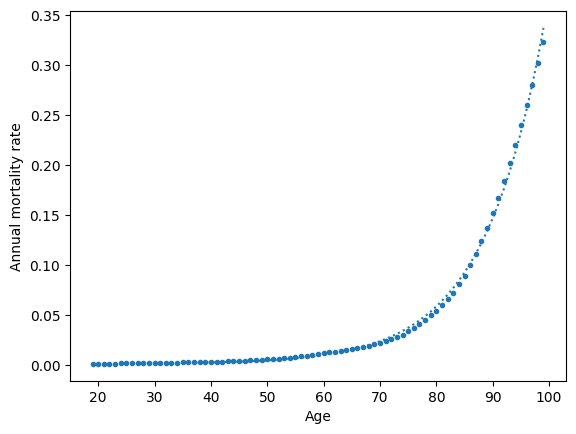

In [5]:
life_table = pd.DataFrame({
    "Age bin lower" : np.linspace(0,99,100),
    "Age bin upper" : np.linspace(1,100,100),
    "Mortality" : [0.00544568942859769, 0.00040257113869302, 0.000254236627370119, 0.000191887069377117, 0.000161350340931676, 0.000142866410897113, 0.000129908919916488, 0.000119035452371463, 0.000107113170088269, 9.54861170612276E-05, 8.99308070074767E-05, 9.98268587864004E-05, 0.000135970505652949, 0.000204669006052427, 0.000298894156003371, 0.000405212253099307, 0.000513052917085588, 0.000622979365289211, 0.000730827625375241, 0.000836958352010697, 0.000949320499785244, 0.00106480985414237, 0.00116985128261149, 0.00125857908278704, 0.00133492052555084, 0.00140560872387141, 0.00147951999679208, 0.00156003492884338, 0.00165091559756547, 0.00174883368890733, 0.00184925447683781, 0.0019465348450467, 0.00203970144502819, 0.0021280434448272, 0.00221556331962347, 0.00230809138156474, 0.0024092432577163, 0.00251883920282125, 0.00263827270828187, 0.00276825693435967, 0.00291649089194834, 0.00307848490774632, 0.00324352458119392, 0.00340965297073126, 0.00358722521923482, 0.00379202072508633, 0.00403583887964487, 0.00431524869054556, 0.00462507316842675, 0.00495934067294002, 0.00530762085691094, 0.00568565167486668, 0.00611765449866652, 0.00661950511857867, 0.00718422327190638, 0.00776646938174963, 0.00836908537894487, 0.00904176104813814, 0.00979499705135822, 0.0106063261628151, 0.0114669734612107, 0.0123334797099233, 0.0131734628230333, 0.0139807434752584, 0.0147979333996773, 0.0156656913459301, 0.0167256686836481, 0.0178528390824795, 0.0191221758723259, 0.0205258037894964, 0.0219193808734417, 0.0235364474356174, 0.0253724660724401, 0.0276162438094616, 0.0298890620470047, 0.0337258204817772, 0.0369334556162357, 0.0410163439810276, 0.0447582602500916, 0.0495301112532616, 0.0541197210550308, 0.059482529759407, 0.0654013901948929, 0.0722243711352348, 0.0806085169315338, 0.0891392305493355, 0.0995857492089272, 0.11102119833231, 0.123483829200268, 0.137000516057014, 0.15158386528492, 0.167229443788528, 0.183913290500641, 0.201589778065681, 0.220190301537514, 0.239622786641121, 0.259772449731827, 0.280503511428833, 0.301662474870682, 0.323082149028778]
})

def gm_hazard(x, alpha, beta, gamma):
    return alpha * np.exp(beta * x) + gamma

xdata = life_table["Age bin lower"][19:]
ydata = life_table["Mortality"][19:]
popt, pcov = sp.optimize.curve_fit(
    gm_hazard,
    xdata,
    ydata,
    bounds=(0,[1,1,1]),
)
plt.plot(xdata, gm_hazard(xdata, *popt), linestyle=":")
plt.scatter(
    xdata,
    ydata,
    marker="."
)
print("fit:\th(Age) = %5.6f exp(%5.6f Age) + %5.6f" % tuple(popt))

plt.xlabel("Age")
plt.ylabel("Annual mortality rate")
plt.show()

The CDC additionally presents a model to predict the mortality rates of gender and race subgroups using the following model:
$$h_{subgroup}(Age) = \sigma (\alpha + \beta \sigma^{-1} (h(Age)))$$

where $\sigma = 1/(1+e^{-x})$ is the standard logistic function and $\alpha$ and $\beta$ are:
|                     | $\ln(\alpha)$  | $\beta$      |
|---------------------|------------|-----------|
| Black, non-Hispanic | -10.88583  | 0.1024042 |
| White, non-Hispanic | -13.43067  | 0.1314234 |
| Male                | -13.27525  | 0.1315896 |
| Female              | -13.92228  | 0.1352526 |
| Hispanic            | -0.2309524 | 0.9664515 |


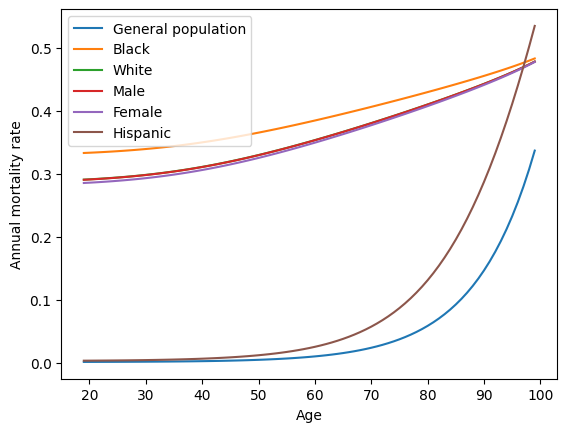

In [14]:
def sigma(x):
    return 1/(1+np.exp(-x))
def invsigma(x):
    return np.log(x/(1-x))
def general_hazard(age):
    return 0.000034 * np.exp(0.092899 * age) + 0.000915
def subgroup_hazard(age, lnalpha, beta):
    alpha = np.exp(lnalpha)
    return sigma(alpha + beta * invsigma(general_hazard(age)))

plt.plot(xdata, general_hazard(xdata), label="General population")
plt.plot(xdata, subgroup_hazard(xdata, -10.88583, 0.1024042), label="Black")
plt.plot(xdata, subgroup_hazard(xdata, -13.43067, 0.1314234), label="White")
plt.plot(xdata, subgroup_hazard(xdata, -13.27525, 0.1315896), label="Male")
plt.plot(xdata, subgroup_hazard(xdata, -13.92228, 0.1352526), label="Female")
plt.plot(xdata, subgroup_hazard(xdata, -0.2309524, 0.9664515), label="Hispanic")

plt.xlabel("Age")
plt.ylabel("Annual mortality rate")
plt.legend()
plt.show()